# Bone Fracture Detection

This workbook looks at detection of bone fractures in the "human-bone-fractures-image-dataset" on Kaggle.

Here are some example images:

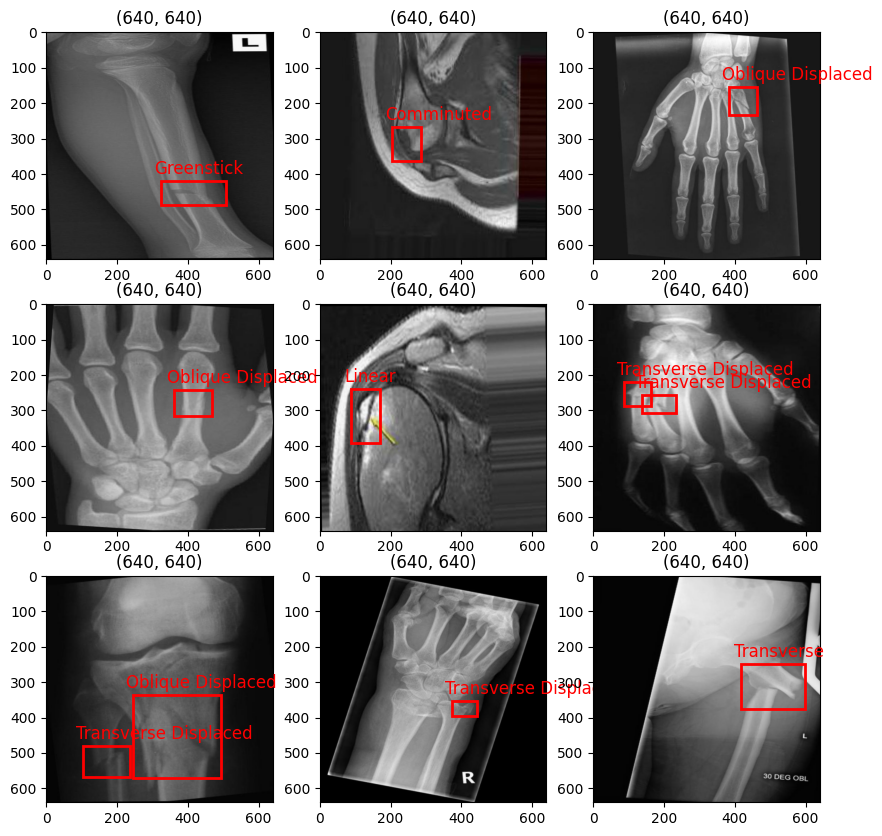

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pathlib

# Define paths to the training images and labels directories
train_images_dir = pathlib.Path(
    "/kaggle/input/human-bone-fractures-image-dataset-hbfmid/"
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)/"
    "Bone Fractures Detection/train/images"
)
train_labes_dir = pathlib.Path(
    "/kaggle/input/human-bone-fractures-image-dataset-hbfmid/"
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)/"
    "Bone Fractures Detection/train/labels"
)

# Get a list of all .jpg image files in the training images directory
train_images = list(train_images_dir.glob("*.jpg"))

# Define the class names corresponding to the class IDs in the label files (data.yaml)
class_names = [
    'Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced',
    'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse'
]

# Create a 3x3 grid of subplots to display 9 images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop through the first 9 images and their corresponding axes
for i, ax in enumerate(axes.flat):
    # Open the image using PIL
    img = Image.open(train_images[i])
    
    # Display the image in the subplot
    ax.imshow(img)
    
    # Set the subplot title to the image size (width, height)
    ax.set_title(img.size)
    
    # Optional: hide axis ticks
    # ax.axis("off")

    # Construct the path to the corresponding label file
    label_path = train_labes_dir / f"{train_images[i].stem}.txt"
    
    # If the label file exists, read and parse it
    if label_path.exists():
        with open(label_path, "r") as f:
            lines = f.readlines()
        
        # Get image dimensions
        img_width, img_height = img.size
        
        # Loop through each line in the label file
        for line in lines:
            # Split the line into class ID and bounding box values
            values = line.strip().split()
            class_id = int(values[0])
            x_center, y_center, width, height = map(float, values[1:])

            # Convert normalized YOLO coordinates to pixel values
            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)
            box_width = int(width * img_width)
            box_height = int(height * img_height)

            # Draw the bounding box on the image
            rect = patches.Rectangle(
                (x1, y1), box_width, box_height,
                linewidth=2, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

            # Add the class name label near the bounding box
            ax.text(x1 - 20, y1 - 20, class_names[class_id], color="r", fontsize=12)



You Only Look Once (YOLO) is a real-time object detection algorithm introduced by Redmon et al. in 2016. Unlike traditional object detection methods that repurpose classifiers or localizers to perform detection in a multi-stage pipeline, YOLO reframes object detection as a single regression problem, directly predicting bounding boxes and class probabilities from full images in one evaluation.

The core idea behind YOLO is to divide the input image into an S × S grid, where each grid cell is responsible for detecting objects whose centers fall within it. For each cell, the model predicts a fixed number of bounding boxes, each with:

Coordinates (x, y, width, height) relative to the cell,
A confidence score indicating the likelihood that the box contains an object and how accurate the bounding box is,
Class probabilities for each object category.
The final detection confidence for each class is computed by multiplying the confidence score with the class probability.

Because YOLO processes the entire image in a single forward pass of a convolutional neural network (CNN), it achieves high speed and efficiency, making it particularly well-suited for real-time applications such as autonomous driving, surveillance, and robotics. Additionally, by considering global context during prediction, YOLO tends to make fewer background errors compared to region-based methods.

Over time, YOLO has evolved through multiple versions (YOLOv2, YOLOv3, YOLOv4, YOLOv5, and beyond), each improving accuracy, speed, and architectural design.

Algorithm input-output: 

- Input Image: The image is processed as a whole.

- Grid Division: The image is divided into a grid (e.g., 3×3). Each grid cell is responsible for detecting objects whose centers fall within it.

- Bounding Boxes: Each cell predicts a fixed number of bounding boxes, along with:

  - Confidence scores (how likely it is that a box contains an object),

  - Class probabilities (what kind of object it might be).
 
First, we need to install and load the YOLO library

In [2]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
# build a new model from YAML and transfer weights from a pretrained model (recommended for training)
model = YOLO("yolo11n.yaml").load("yolo11n.pt") 
#print(model.model) # Prints a summary of the model architecture
for name, param in model.named_parameters():
    print(name)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 110MB/s]


Transferred 499/499 items from pretrained weights
model.model.0.conv.weight
model.model.0.bn.weight
model.model.0.bn.bias
model.model.1.conv.weight
model.model.1.bn.weight
model.model.1.bn.bias
model.model.2.cv1.conv.weight
model.model.2.cv1.bn.weight
model.model.2.cv1.bn.bias
model.model.2.cv2.conv.weight
model.model.2.cv2.bn.weight
model.model.2.cv2.bn.bias
model.model.2.m.0.cv1.conv.weight
model.model.2.m.0.cv1.bn.weight
model.model.2.m.0.cv1.bn.bias
model.model.2.m.0.cv2.conv.weight
model.model.2.m.0.cv2.bn.weight
model.model.2.m.0.cv2.bn.bias
model.model.3.conv.weight
model.model.3.bn.weight
model.model.3.bn.bias
model.model.4.cv1.conv.weight
model.model.4.cv1.bn.weight
model.model.4.cv1.bn.bias
model.model.4.cv2.conv.weight
model.model.4.cv2.bn.weight
model.model.4.cv2.bn.bias
model.model.4.m.0.cv1.conv.weight
model.model.4.m.0.cv1.bn.weight
model.model.4.m.0.cv1.bn.bias
model.model.4.m.0.cv2.conv.weight
model.model.4.m.0.cv2.bn.weight
model.model.4.m.0.cv2.bn.bias
model.model.5.

## YOLO11n Model Architecture Overview

The YOLO11n model follows a modular architecture typical of modern object detectors, structured into three main components: **Backbone**, **Neck**, and **Head**.

---

### Backbone (Layers 0–9)
The backbone is responsible for extracting hierarchical features from the input image.

| Layer | Type     | Description |
|-------|----------|-------------|
| 0–1   | `Conv`   | Initial downsampling and feature extraction. |
| 2     | `C3k2`   | Lightweight residual block with 2 convolutions. |
| 3–5   | `Conv` + `C3k2` | Further downsampling and feature enrichment. |
| 6–9   | `C3k2`, `Conv`, `SPPF` | High-level features and spatial pyramid pooling for multi-scale context. |

---

### Neck (Layers 10–22)
The neck fuses features from different scales using upsampling and concatenation to enhance spatial and semantic information.

| Layer | Type     | Description |
|-------|----------|-------------|
| 10    | `C2PSA`  | Attention-enhanced block for feature refinement. |
| 11–12 | `Upsample` + `Concat` | Merge high-level and mid-level features. |
| 13    | `C3k2`   | Feature fusion. |
| 14–15 | `Upsample` + `Concat` | Merge with low-level features. |
| 16    | `C3k2`   | Final fusion block. |
| 17–22 | `Conv`, `Concat`, `C3k2` | Downsample and merge again for multi-scale detection. |

---

### Head (Layer 23)
The head performs final object detection by predicting bounding boxes, objectness scores, and class probabilities.

| Layer | Type     | Description |
|-------|----------|-------------|
| 23    | `Detect` | Outputs predictions at 3 scales: `[64, 128, 256]` channels. |

---



In [4]:
# We are going to freeze the first 10 layers of the YOLO model as we 
# 1) want to speed up training, 
# 2) have a small dataset and want to avoid overfitting
# 3) want to retain low-level features from the pretrained model.
def freeze_layer(trainer):
    model = trainer.model
    num_freeze = 10
    print(f"Freezing {num_freeze} layers")
    freeze = [f'model.{x}.' for x in range(num_freeze)]  # layers to freeze 
    for k, v in model.named_parameters(): 
        v.requires_grad = True  # train all layers 
        if any(x in k for x in freeze): 
            print(f'freezing {k}') 
            v.requires_grad = False 
    print(f"{num_freeze} layers are freezed.")


model.add_callback("on_train_start", freeze_layer)

# Train the model
data_yaml='/kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/data.yaml'

train_results = model.train(data=data_yaml, epochs=50, imgsz=640)

Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=N

100%|██████████| 755k/755k [00:00<00:00, 22.8MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/train/labels... 1347 images, 3 backgrounds, 0 corrupt: 100%|██████████| 1347/1347 [00:03<00:00, 360.36it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9.2±2.2 MB/s, size: 25.1 KB)


val: Scanning /kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/valid/labels... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 333.34it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Freezing 10 layers
freezing model.0.conv.weight
freezing model.0.bn.weight
freezing model.0.bn.bias
freezing model.1.conv.weight
freezing model.1.bn.weight
freezing model.1.bn.bias
freezing model.2.cv1.conv.weight
freezing model.2.cv1.bn.weight
freezing model.2.cv1.bn.bias
freezing model.2.cv2.conv.weight
freezing model.2.cv2.bn.weight
freezing model.2.cv2.bn.bias
freezing model.2.m.0.cv1.conv.weight
freezing model.2.m.0.cv1.bn.weight
freezing model.2.m.0.cv1.bn.bias
freezing model.2.m.0.cv2.conv.weight
freezing model.2.m.0.cv2.bn.weight
freezing model.2.m.0.cv2.bn.bias
freezing model.3.conv.weight
freezing model.3.bn.weight
freezing model.3.bn.bias
freezing 

       1/50      1.28G      2.535       5.67      2.364          5        640: 100%|██████████| 85/85 [00:14<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        128        157    0.00124      0.364     0.0462     0.0179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.67G      2.209      4.626      2.057          9        640: 100%|██████████| 85/85 [00:12<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

                   all        128        157      0.673      0.152      0.158     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.68G      2.128      4.077      2.018          3        640: 100%|██████████| 85/85 [00:12<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

                   all        128        157      0.508      0.122      0.111     0.0519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.69G      2.066      3.677      1.964          5        640: 100%|██████████| 85/85 [00:12<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

                   all        128        157      0.365       0.29      0.218     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.71G      2.066      3.323      1.965          5        640: 100%|██████████| 85/85 [00:11<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


                   all        128        157      0.725      0.192      0.232      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.71G      1.973      3.063       1.87          5        640: 100%|██████████| 85/85 [00:12<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


                   all        128        157      0.698      0.272      0.323      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.72G       1.93      2.836      1.877          4        640: 100%|██████████| 85/85 [00:12<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


                   all        128        157      0.665      0.253      0.296      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.73G      1.898       2.64      1.835          5        640: 100%|██████████| 85/85 [00:12<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


                   all        128        157      0.546      0.253      0.344      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.75G       1.85      2.418       1.78          3        640: 100%|██████████| 85/85 [00:12<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


                   all        128        157      0.517      0.336      0.358      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.76G      1.851      2.342      1.781          5        640: 100%|██████████| 85/85 [00:12<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


                   all        128        157      0.811      0.401      0.487      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.77G      1.816      2.221      1.775          5        640: 100%|██████████| 85/85 [00:12<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


                   all        128        157      0.623      0.402      0.477       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.77G       1.79      2.055      1.722          4        640: 100%|██████████| 85/85 [00:12<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

                   all        128        157      0.728      0.523      0.584      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.79G      1.764      2.008      1.716          4        640: 100%|██████████| 85/85 [00:11<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


                   all        128        157      0.714       0.49      0.594      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       1.8G      1.742      1.955      1.691          9        640: 100%|██████████| 85/85 [00:12<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

                   all        128        157      0.812      0.513      0.629      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.81G      1.764      1.906      1.693          5        640: 100%|██████████| 85/85 [00:12<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

                   all        128        157      0.723      0.566      0.623      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.81G      1.704      1.816      1.655          5        640: 100%|██████████| 85/85 [00:12<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        128        157      0.673      0.567       0.62      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.83G       1.71      1.814      1.667          3        640: 100%|██████████| 85/85 [00:12<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

                   all        128        157      0.787      0.573      0.671      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.84G      1.704      1.732      1.645          4        640: 100%|██████████| 85/85 [00:12<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


                   all        128        157      0.684      0.681      0.705      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.85G      1.666      1.643      1.612          8        640: 100%|██████████| 85/85 [00:12<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]

                   all        128        157      0.539      0.693      0.642       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.86G      1.624      1.673      1.614          6        640: 100%|██████████| 85/85 [00:11<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


                   all        128        157      0.712      0.614      0.699      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.88G      1.634      1.592      1.582          7        640: 100%|██████████| 85/85 [00:12<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

                   all        128        157      0.819      0.627      0.725      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.88G      1.611      1.572      1.569          4        640: 100%|██████████| 85/85 [00:11<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]

                   all        128        157      0.689       0.67      0.717      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.89G      1.569      1.497      1.557          5        640: 100%|██████████| 85/85 [00:11<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

                   all        128        157      0.816      0.639      0.753      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       1.9G      1.585      1.496      1.562          9        640: 100%|██████████| 85/85 [00:12<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

                   all        128        157      0.668      0.731      0.761      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.92G      1.555      1.448      1.536          4        640: 100%|██████████| 85/85 [00:12<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

                   all        128        157      0.736      0.673      0.762      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.93G       1.53      1.399      1.521          4        640: 100%|██████████| 85/85 [00:12<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

                   all        128        157      0.793      0.634       0.76      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.94G      1.531      1.392      1.521          7        640: 100%|██████████| 85/85 [00:11<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


                   all        128        157      0.781      0.683      0.754      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.94G      1.522      1.392      1.507          4        640: 100%|██████████| 85/85 [00:12<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]

                   all        128        157      0.826      0.727      0.786      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.96G      1.556      1.364      1.516         12        640: 100%|██████████| 85/85 [00:11<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

                   all        128        157      0.747      0.749      0.757      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.97G      1.496      1.309      1.477          3        640: 100%|██████████| 85/85 [00:11<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


                   all        128        157      0.801      0.746      0.793      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.98G      1.479      1.308      1.484          5        640: 100%|██████████| 85/85 [00:12<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

                   all        128        157      0.827      0.729      0.802      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.98G      1.484      1.306      1.465          8        640: 100%|██████████| 85/85 [00:11<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]

                   all        128        157      0.887      0.688      0.807      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         2G      1.453      1.266      1.458          7        640: 100%|██████████| 85/85 [00:12<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

                   all        128        157      0.831      0.716      0.815      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.01G      1.452      1.224      1.456          8        640: 100%|██████████| 85/85 [00:12<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

                   all        128        157      0.827      0.734      0.821      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.02G      1.455      1.248      1.443          7        640: 100%|██████████| 85/85 [00:12<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


                   all        128        157      0.851      0.677      0.803      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.03G      1.453      1.214      1.445          6        640: 100%|██████████| 85/85 [00:12<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

                   all        128        157      0.876        0.7      0.812      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.04G       1.42        1.2      1.415          5        640: 100%|██████████| 85/85 [00:12<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

                   all        128        157      0.774      0.765      0.826      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.05G      1.413      1.171      1.411          5        640: 100%|██████████| 85/85 [00:12<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


                   all        128        157      0.884      0.753      0.846       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.06G      1.417      1.164      1.422          3        640: 100%|██████████| 85/85 [00:11<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


                   all        128        157      0.838      0.765      0.857      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.07G      1.405      1.162      1.418          2        640: 100%|██████████| 85/85 [00:11<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

                   all        128        157      0.897      0.733      0.851      0.447


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.09G      1.413      1.047      1.506          3        640: 100%|██████████| 85/85 [00:12<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


                   all        128        157      0.787      0.773      0.829      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.1G      1.371     0.9917      1.481          3        640: 100%|██████████| 85/85 [00:11<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


                   all        128        157      0.729      0.791      0.837      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.11G       1.34     0.9418      1.448          5        640: 100%|██████████| 85/85 [00:11<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

                   all        128        157       0.74      0.803      0.858      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.11G      1.307     0.9119      1.426          4        640: 100%|██████████| 85/85 [00:11<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


                   all        128        157      0.851      0.792      0.865      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.13G      1.318     0.9225      1.419          3        640: 100%|██████████| 85/85 [00:11<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

                   all        128        157      0.881      0.793      0.869      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.14G      1.276     0.8793      1.391          3        640: 100%|██████████| 85/85 [00:11<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

                   all        128        157      0.856      0.818      0.867      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.15G      1.282     0.8709      1.398          3        640: 100%|██████████| 85/85 [00:11<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]

                   all        128        157        0.9      0.799      0.881      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.15G      1.283      0.877      1.416          3        640: 100%|██████████| 85/85 [00:11<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

                   all        128        157      0.877      0.785      0.872      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.17G       1.26     0.8412       1.38          4        640: 100%|██████████| 85/85 [00:11<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


                   all        128        157      0.877      0.805      0.874      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.18G      1.273     0.8557      1.382          2        640: 100%|██████████| 85/85 [00:11<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

                   all        128        157      0.878      0.785      0.872      0.472



50 epochs completed in 0.185 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        128        157      0.901      0.798       0.88       0.48
            Comminuted         15         15      0.927      0.667      0.744      0.454
            Greenstick         10         10      0.987        0.4      0.573      0.246
               Healthy          7          7      0.929          1      0.995       0.75
                Linear          1          1      0.734          1      0.995      0.405
     Oblique Displaced         30         30      0.892      0.825      0.899      0.394
               Oblique          7          7      0.846      0.788        0.9      0.558
             Segmental          3          3          1      0.561      0.913      0.707
                Spiral          5          5      0.918          1      0.995      0.441
  Transverse Displaced         53         65      0.945      0.815      0.853      0.347
            Transverse         11         14      0.831      0.929      0.932      0.501
Speed: 0.2ms preproce


image 1/1 /kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/test/images/101_jpg.rf.92e32f9dfb9b34f9a123b16629cc368d.jpg: 640x640 1 Spiral, 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


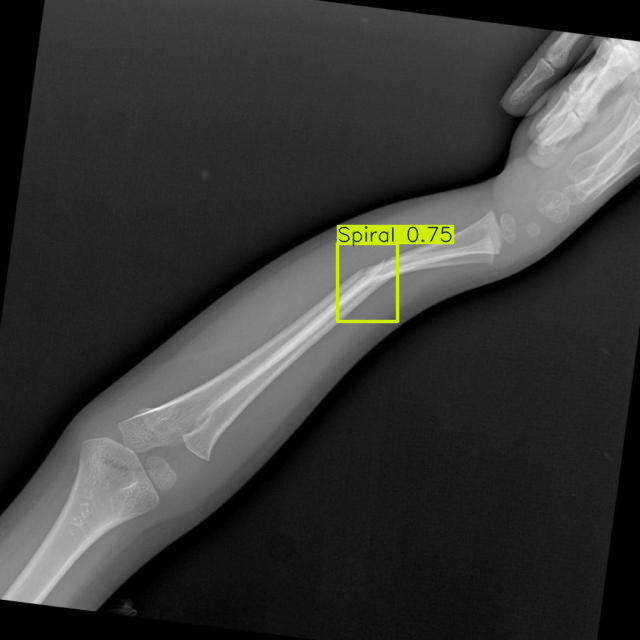

In [5]:
# Perform object detection on an image
myimage = pathlib.Path(
    "/kaggle/input/human-bone-fractures-image-dataset-hbfmid/"
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)/"
    "Bone Fractures Detection/test/images/101_jpg.rf.92e32f9dfb9b34f9a123b16629cc368d.jpg"
)
results = model(myimage)  # Predict on an image
results[0].show()  # Display results

In [6]:
best_model=YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
best_model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

## Predict test dataset

In [7]:
#metrics = model.val(split='test') # Evaluates on the test set
# when revoking the script w/o re-running the training
best_model=YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
metrics_best_model = best_model.val(split='test')


Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9.3±1.1 MB/s, size: 28.5 KB)


val: Scanning /kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/test/labels... 64 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64/64 [00:00<00:00, 348.57it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         64         66      0.901      0.853      0.899      0.485
            Comminuted          9          9          1      0.489      0.573      0.337
            Greenstick          1          1      0.797          1      0.995      0.502
               Healthy          3          3      0.928          1      0.995      0.788
     Oblique Displaced         16         17      0.932      0.804      0.903      0.395
               Oblique          2          2      0.878          1      0.995      0.598
                Spiral          3          3      0.904          1      0.995      0.467
  Transverse Displaced         22         23      0.947      0.783      0.944      0.401
            Transverse          8          8      0.819       0.75      0.795      0.394
Speed: 5.1ms preprocess, 7.9ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/detect/val


### Output Description

| **Column**     | **Description**                                                                 |
|----------------|----------------------------------------------------------------------------------|
| **Class**      | The name of the object class (e.g., *Comminuted*, *Greenstick*, etc.)           |
| **Images**     | Number of test images containing at least one instance of this class            |
| **Instances**  | Total number of ground truth objects of this class in the test set              |
| **Box(P)**     | **Precision**: Proportion of predicted boxes that are correct                   |
| **R**          | **Recall**: Proportion of actual objects that were correctly detected           |
| **mAP50**      | Mean Average Precision at IoU threshold 0.5 — standard detection metric         |
| **mAP50-95**   | Mean Average Precision averaged over IoU thresholds from 0.5 to 0.95 — stricter |


## Understanding mAP50 and mAP50-95 in Object Detection

**mAP** stands for **mean Average Precision**. It is a key metric used to evaluate object detection models, combining both **precision** and **recall** across different thresholds and classes.


Before diving into mAP, it's important to understand **IoU** (Intersection over Union):

$$
\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
$$

- IoU measures how much the predicted bounding box overlaps with the ground truth box.
- A prediction is considered **correct** if its IoU with the ground truth is above a certain threshold (e.g., 0.5).


**mAP50** means **mean Average Precision at IoU = 0.5**.
- It evaluates how well the model detects objects when the predicted box overlaps **at least 50%** with the ground truth.
- This is a **standard and lenient** metric.
- Computation:
  1. Calculate **Average Precision (AP)** for each class at IoU = 0.5.
  2. Take the **mean** of all APs across classes.


**mAP50-95** is a  **stricter and more comprehensive** metric.
- It averages AP over **10 IoU thresholds**: from **0.5 to 0.95**, in steps of 0.05:
  
IoU thresholds= [0.5, 0.55, 0.6, ..., 0.95]

- For each threshold, AP is computed per class, and then averaged.
- Finally, the mean of all these APs is taken — giving mAP50-95.

**Why Both Matter**
- mAP50 tells you: "Can the model find the object?"
- mAP50-95 tells you: "Can the model find the object *precisely*?"

## Interpretation

**Overall Performance (all)**

Images: 64 test images

Instances: 66 total objects across all classes

Precision: 0.901 → 90.1% of predicted boxes were correct

Recall: 0.853 → 85.3% of actual objects were detected

mAP50: 0.899 → Very good detection performance at IoU 0.5

mAP50-95: 0.485 → Moderate performance across stricter IoU thresholds

**Class: Comminuted**

Instances: 9

Precision: 1.0 → All predicted boxes were correct

Recall: 0.489 → Only about half of the actual instances were detected

mAP50: 0.573 → Moderate detection quality

mAP50-95: 0.337 → Lower performance under stricter IoU thresholds

This suggests the model is very precise for this class but misses many instances (low recall).

**Class: Greenstick**

Only 1 instance, but it was detected with high precision and recall, resulting in high mAP scores.

**Key Takeaways**

The model performs well overall, especially at IoU 0.5.

mAP50-95 is lower, which is typical — it reflects stricter evaluation.

Some classes like Comminuted and Transverse have lower recall, suggesting the model might be missing some instances.

Classes with very few instances (like Greenstick, Oblique) can show high variance in metrics due to small sample size.

The code below shows some more examples from our predictions:


image 1/1 /kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/test/images/2_jpg.rf.2cb0dcef4a00467b465903250f75ebf5.jpg: 640x640 (no detections), 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/test/images/210_jpg.rf.d032055fe1f23f1ada7615d73488b92f.jpg: 640x640 1 Oblique, 8.4ms
Speed: 1.4ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/human-bone-fractures-image-dataset-hbfmid/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/test/images/50_jpg.rf.cb7038a99adba42fcc018ef4f4a44d7c.jpg: 640x640 2 Transverse Displaceds, 8.7ms
Speed: 1.5ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640

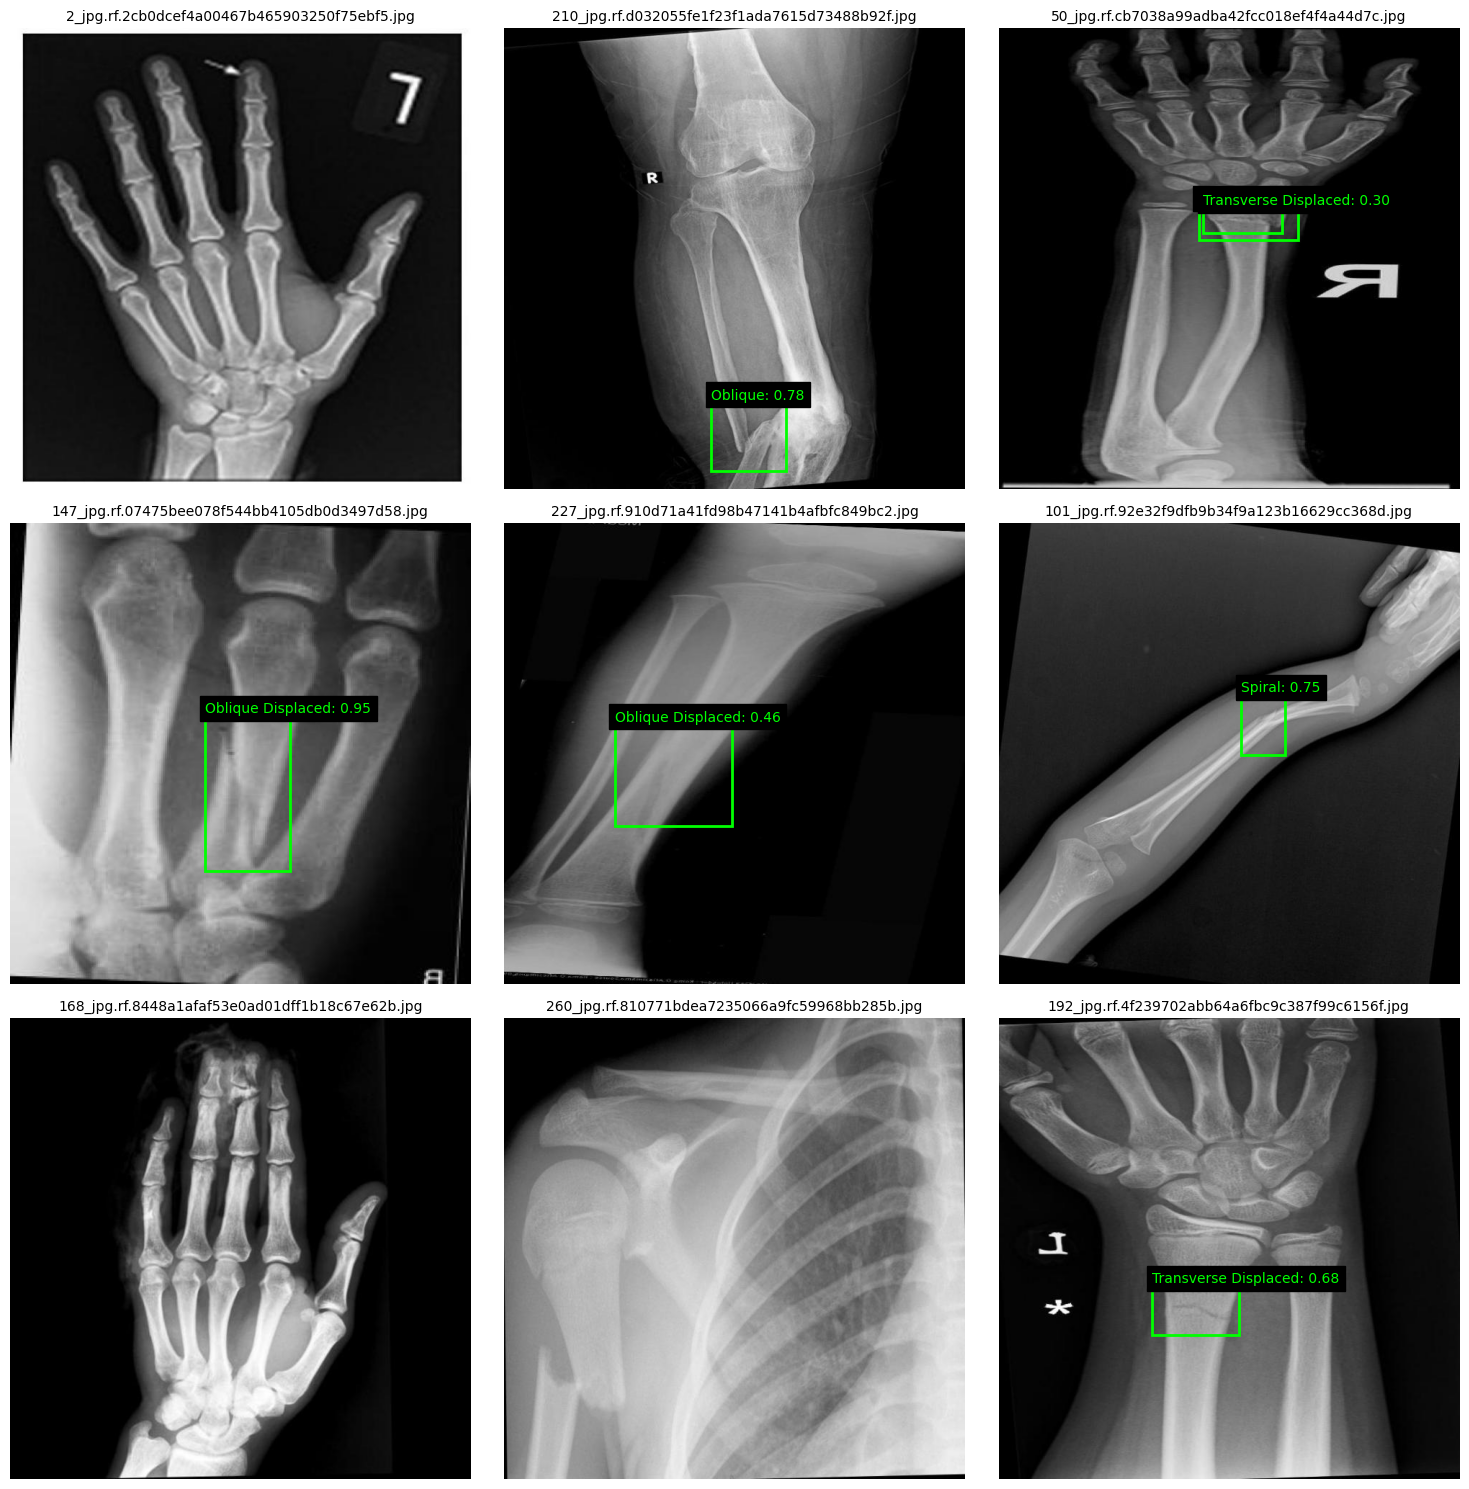

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import pathlib

# List of 9 test images (update this with your actual test image paths)
test_images = list(pathlib.Path("/kaggle/input/human-bone-fractures-image-dataset-hbfmid/"
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)/"
    "Bone Fractures Detection/test/images/").glob("*.jpg"))[:9]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Loop through the first 9 images and their corresponding axes
for i, ax in enumerate(axes.flat):
    img_path = test_images[i]
    
    # Perform prediction
    results = best_model(img_path)
    result = results[0]

    # Load image
    img = Image.open(img_path)
    ax.imshow(img)
    
    # Set title to image name or size
    ax.set_title(img_path.name, fontsize=10)
    ax.axis("off")

    # Draw predicted bounding boxes
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])
        conf = float(box.conf[0])

        # Draw rectangle
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

        # Add class label and confidence
        label = f"{class_names[class_id]}: {conf:.2f}"
        ax.text(x1, y1 - 10, label, color='lime', fontsize=10, backgroundcolor='black')

plt.tight_layout()
plt.show()
